## Credit Card Applications
<p>Commercial banks receive <em>a lot</em> of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do.</p>

<p>We'll use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. The structure of this notebook is as follows:</p>
<ul>
<li>First, we will start off by loading and viewing the dataset.</li>
<li>We will see that the dataset has a mixture of both numerical and non-numerical features, that it contains values from different ranges, plus that it contains a number of missing entries.</li>
<li>We will have to preprocess the dataset to ensure the machine learning model we choose can make good predictions.</li>
<li>After our data is in good shape, we will do some exploratory data analysis to build our intuitions.</li>
<li>Finally, we will build a machine learning model that can predict if an individual's application for a credit card will be accepted.</li>
</ul>
<p>First, loading and viewing the dataset. We find that since this data is confidential, the contributor of the dataset has anonymized the feature names.</p>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# Load dataset
cc_apps = pd.read_csv("datasets/cc_approvals.data", header=None)
colname = ['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 
                  'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 
                  'ZipCode', 'Income', 'Approval']
cc_apps.columns = colname

# Inspect data
cc_apps.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approval
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## 1. Data exploration and transformation
<p> The dataset has a mixture of numerical and non-numerical features. This can be fixed with some preprocessing, but before we do that, let's learn about the dataset a bit more to see if there are other dataset issues that need to be fixed.</p>

In [6]:
# Print summary statistics
cc_apps_description = cc_apps.describe()
print(cc_apps_description)

print("\n")

# Print DataFrame information
cc_apps_info = cc_apps.info()
print(cc_apps_info)

print("\n")

             Debt  YearsEmployed  CreditScore         Income
count  690.000000     690.000000    690.00000     690.000000
mean     4.758725       2.223406      2.40000    1017.385507
std      4.978163       3.346513      4.86294    5210.102598
min      0.000000       0.000000      0.00000       0.000000
25%      1.000000       0.165000      0.00000       0.000000
50%      2.750000       1.000000      0.00000       5.000000
75%      7.207500       2.625000      3.00000     395.500000
max     28.000000      28.500000     67.00000  100000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
Gender            690 non-null object
Age               690 non-null object
Debt              690 non-null float64
Married           690 non-null object
BankCustomer      690 non-null object
EducationLevel    690 non-null object
Ethnicity         690 non-null object
YearsEmployed     690 non-null float64
PriorDefault      690 non-null object


**1) Handling the missing values**
<p>We've uncovered some issues that will affect the performance of our machine learning model(s) if they go unchanged:</p>
<ul>
<li>Our dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code> and <code>object</code> types). Specifically, the features 2, 7, 10 and 14 contain numeric values (of types float64, float64, int64 and int64 respectively) and all the other features contain non-numeric values.</li>
<li>The dataset also contains values from several ranges. Some features have a value range of 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, we can get useful statistical information (like <code>mean</code>, <code>max</code>, and <code>min</code>) about the features that have numerical values. </li>
<li>Finally, the dataset has missing values, which we'll take care of in this task. The missing values in the dataset are labeled with '?', which can be seen in the last cell's output.</li>
</ul>
<p>For numeric features, the missing value question marks can be replaced with NaN, or can be replaced with the mean values. Since some models cannot handle missing values, such as LDA, we use the second method. </p>

In [23]:
# convert missing value to NAN
cc_apps = cc_apps.replace('?', np.nan)

# Impute the missing values with mean imputation
cc_apps.fillna(cc_apps.mean(), inplace=True)

# Count the number of NaNs in the dataset to verify
pd.isna(cc_apps).sum(axis=0)

Gender            12
Age               12
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriversLicense     0
Citizen            0
ZipCode           13
Income             0
Approval           0
dtype: int64

**2) Handling the missing values**
<p>There are still some missing values to be imputed for object columns. All of them contain non-numeric data. </p>
<p>We are going to impute these missing values with the most frequent values as present in the respective columns. This is <a href="https://www.datacamp.com/community/tutorials/categorical-data">good practice</a> when it comes to imputing missing values for categorical data in general.</p>

In [24]:
# Iterate over each column of cc_apps
for col in cc_apps.columns:
    # Check if the column is of object type
    if cc_apps[col].dtypes == 'object':
        # Impute with the most frequent value
        cc_apps = cc_apps.fillna(cc_apps[col].value_counts().index[0])

# Count the number of NaNs in the dataset and print the counts to verify
# ... YOUR CODE FOR TASK 5 ...
pd.isna(cc_apps).sum()

Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
Approval          0
dtype: int64

## 2. Data preprocession and exploration
<p>The missing values are now successfully handled.</p>
<p>In this step, we will do:</p>

**1) Convert the non-numeric data into numeric.**
<p>First, we will be converting all the non-numeric values into numeric ones. We do this because not only it results in a faster computation but also many machine learning models (like XGBoost, regression and SVM) (and especially the ones developed using scikit-learn) require the data to be in a strictly numeric format. We will do this by  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html">label encoding</a>.</p>

In [25]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in cc_apps.columns:
    # Compare if the dtype is object
    if cc_apps[col].dtypes=='object':
    # Use LabelEncoder to do the numeric transformation
        cc_apps[col]=le.fit_transform(cc_apps[col])
        
cc_apps

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approval
0,1,156,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,0
1,0,328,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,0
2,0,89,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,0
3,1,125,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,0
4,1,43,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,52,10.085,3,3,5,4,1.25,0,0,0,0,0,90,0,1
686,0,71,0.750,2,1,2,8,2.00,0,1,2,1,0,67,394,1
687,0,97,13.500,3,3,6,3,2.00,0,1,1,1,0,67,1,1
688,1,20,0.205,2,1,0,8,0.04,0,0,0,0,0,96,750,1


**2) Check correlations of numeric features**

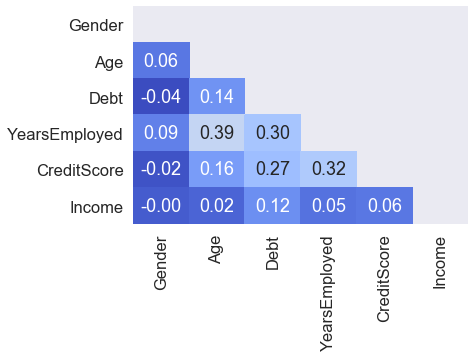

In [26]:
cc_apps['Age'] = pd.to_numeric(cc_apps['Age'])
corr = cc_apps[cc_apps.columns[[0,1,2,7,10,14]]].corr()
sns.set(font_scale=1.5)
mask = np.triu(np.ones_like(corr, dtype=bool))
cfig = sns.heatmap(corr, annot=True, mask = mask, 
                   fmt= '.2f', cmap='coolwarm', cbar=False)

**3) Split the data into train and test sets.**


In [27]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Feature selection; segregate features and labels into separate variables
cc_apps = cc_apps.values
X,y = cc_apps[:,0:-1] , cc_apps[:,-1]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.2,
                                random_state=55)

**4) Scale the feature values to a uniform range.**

In [28]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

**5) Visualization by boxplot (numeric) and countplot (categorical)**

In [29]:
appindex = (y_train == 1)
sns.set(font_scale=1)

def box(variable):
    ind = colname.index(variable)
    app = []
    disapp = []
    for i in range(len(y_train)):
        if appindex[i]:
            app.append(rescaledX_train[i, ind])
        else:
            disapp.append(rescaledX_train[i,ind])    
        
    df = pd.DataFrame([app, disapp], index= ['Approve', 'Disapprove'])
    df.T.boxplot(vert=False)
    plt.show()
    
def hist(variable):
    ind = colname.index(variable)
    app = []
    disapp = []
    for i in range(len(y_train)):
        if appindex[i]:
            app.append(rescaledX_train[i, ind])
        else:
            disapp.append(rescaledX_train[i,ind])   
    
    app = [round(i,1) for i in app]
    disapp = [round(i,1) for i in disapp]
    
    fig, ax = plt.subplots(1,2)
    sns.countplot(app, ax=ax[0]).set_title('Approve')
    sns.countplot(disapp, ax=ax[1]).set_title('Disapprove')

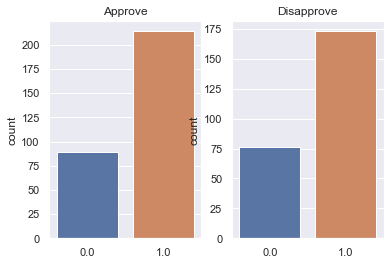

In [30]:
hist('Gender') # no influence

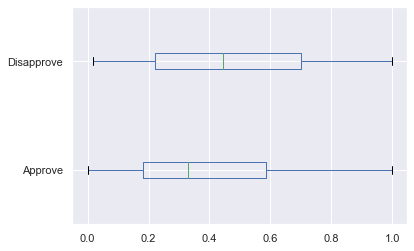

In [31]:
box('Age') # a little influence

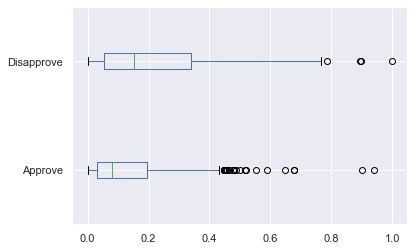

In [32]:
box('Debt') # have influence

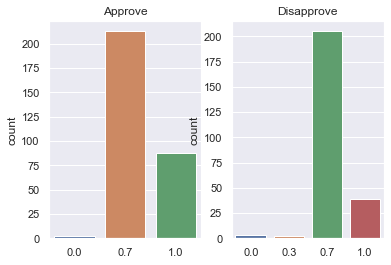

In [33]:
hist('Married') # not so much influence

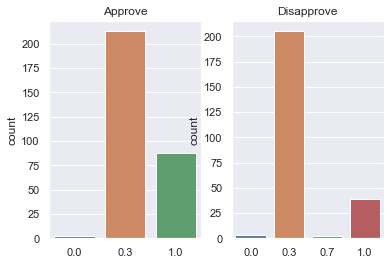

In [35]:
hist('BankCustomer') # not much influence

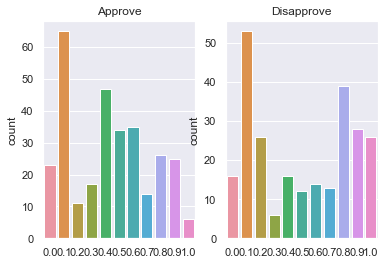

In [36]:
hist('EducationLevel') # a little influence

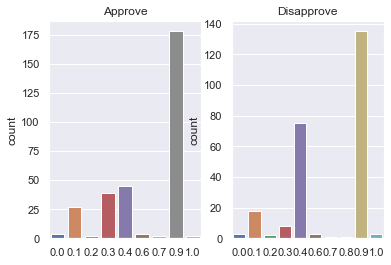

In [37]:
hist('Ethnicity') # not so much influence

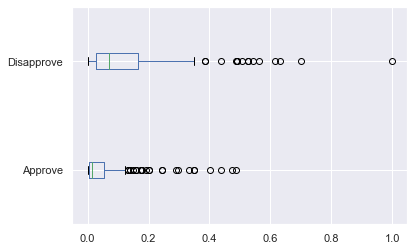

In [38]:
box('YearsEmployed') # have influence

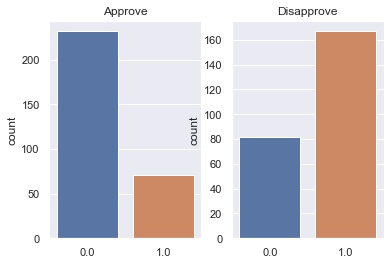

In [39]:
hist('Employed') # significant influence

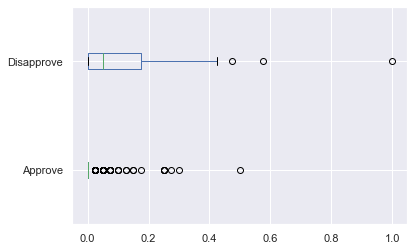

In [40]:
box('CreditScore') # significant influence

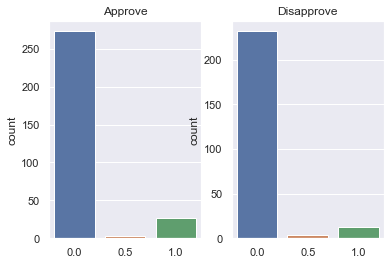

In [41]:
hist('Citizen') # no influence

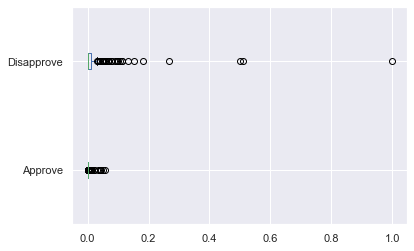

In [42]:
box('Income') # little influence

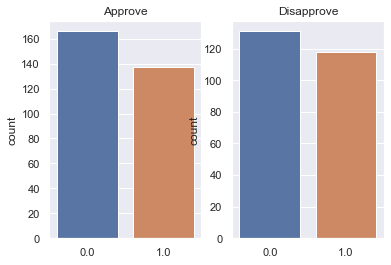

In [43]:
hist('DriversLicense') # little influence

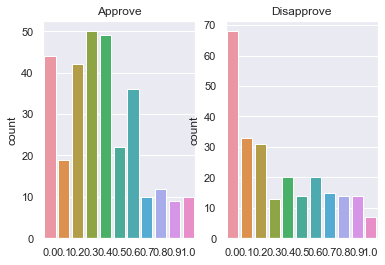

In [44]:
hist('ZipCode') # have some influence

## 3. Machine learning modeling

### [1] Logistic regression

In [49]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression(solver='lbfgs')

# Fit logreg to the train set
logreg.fit(rescaledX_train, y_train)

# cross_validation_score
print(np.mean(cross_val_score(logreg,rescaledX_train, y_train, cv=3)))

0.8586956521739131


**Grid searching and making the model perform better**

In [58]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = {'C': [0.001,0.01,0.1,1,10,100,1000]}

# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

# Fit data to grid_model
grid_model_result = grid_model.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model.best_score_, grid_model.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.856884 using {'C': 10}


**Making predictions and evaluating performance**

In [59]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

# Use logreg to predict instances from the test set and store it
logreg = LogisticRegression(solver='lbfgs', C=10, max_iter=100000)
logreg.fit(rescaledX_train, y_train)
print('For training set:')
y_pred = logreg.predict(rescaledX_train)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logreg.score(rescaledX_train, y_train))

# Print the confusion matrix of the logreg model
print(confusion_matrix(y_train, y_pred))

# Classification report
print(classification_report(y_train, y_pred))

print('For test set:')
y_pred = logreg.predict(rescaledX_test)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logreg.score(rescaledX_test, y_test))

# Print the confusion matrix of the logreg model
print(confusion_matrix(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))

For training set:
Accuracy of logistic regression classifier:  0.8623188405797102
[[228  21]
 [ 55 248]]
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       249
         1.0       0.92      0.82      0.87       303

    accuracy                           0.86       552
   macro avg       0.86      0.87      0.86       552
weighted avg       0.87      0.86      0.86       552

For test set:
Accuracy of logistic regression classifier:  0.8623188405797102
[[55  3]
 [16 64]]
              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85        58
         1.0       0.96      0.80      0.87        80

    accuracy                           0.86       138
   macro avg       0.86      0.87      0.86       138
weighted avg       0.88      0.86      0.86       138



ROC AUC of logistic regression equal to 0.9702586206896552


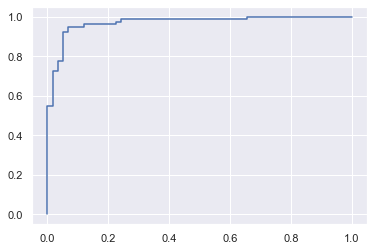

In [60]:
# Print the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt

y_score_l = logreg.fit(rescaledX_test, y_test).decision_function(rescaledX_test)
fpr, tpr, threshold = roc_curve(y_test, y_score_l)
%matplotlib inline
plt.plot(fpr,tpr, label = 'LogisticRegression')
print("ROC AUC of logistic regression equal to", roc_auc_score(y_test, y_score_l))

### [2] Linear SVC model

In [61]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(max_iter=1000000)
lsvc.fit(rescaledX_train, y_train)
print(np.mean(cross_val_score(lsvc,rescaledX_train, y_train, cv=5)))

0.8568174680101286


**Grid searching and making the model perform better**

In [62]:
# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = {'C': [0.01,0.1,1,10,100]}

# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=lsvc, param_grid=param_grid, cv=5)

# Fit data to grid_model
grid_model_result = grid_model.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model.best_score_, grid_model.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.860507 using {'C': 10}


**Making predictions and evaluating performance**

In [63]:
# Use logreg to predict instances from the test set and store it
lsvc = LinearSVC(C=10, max_iter=1000000)
lsvc.fit(rescaledX_train, y_train)
print('For training set:')
y_pred = lsvc.predict(rescaledX_train)

# Get the accuracy score of logreg model and print it
print("Accuracy of linear SVM classifier: ", lsvc.score(rescaledX_train, y_train))

# Print the confusion matrix of the logreg model
print(confusion_matrix(y_train, y_pred))

# Classification report
print(classification_report(y_train, y_pred))

print('For test set:')
y_pred = lsvc.predict(rescaledX_test)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", lsvc.score(rescaledX_test, y_test))

# Print the confusion matrix of the logreg model
print(confusion_matrix(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))

For training set:
Accuracy of linear SVM classifier:  0.8623188405797102
[[234  15]
 [ 61 242]]
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86       249
         1.0       0.94      0.80      0.86       303

    accuracy                           0.86       552
   macro avg       0.87      0.87      0.86       552
weighted avg       0.87      0.86      0.86       552

For test set:
Accuracy of logistic regression classifier:  0.8623188405797102
[[56  2]
 [17 63]]
              precision    recall  f1-score   support

         0.0       0.77      0.97      0.85        58
         1.0       0.97      0.79      0.87        80

    accuracy                           0.86       138
   macro avg       0.87      0.88      0.86       138
weighted avg       0.88      0.86      0.86       138



ROC AUC of SVC equal to 0.9788793103448276


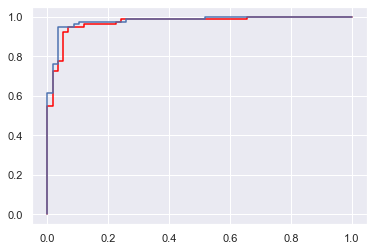

In [64]:
y_score_s = lsvc.fit(rescaledX_test,y_test).decision_function(rescaledX_test)
fprs, tprs, thresholds = roc_curve(y_test, y_score_s)
plt.plot(fpr,tpr,label='LogisticRegression',color='red')
plt.plot(fprs,tprs,label='SVC')
print("ROC AUC of SVC equal to", roc_auc_score(y_test, y_score_s))

### [3] KNeighborsClassifiers

In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(rescaledX_train, y_train)
print(np.mean(cross_val_score(knn,rescaledX_train, y_train, cv=5)))

0.8422714123631554


**Grid searching and making the model perform better**

In [66]:
# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10]}

# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)

# Fit data to grid_model
grid_model_result = grid_model.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model.best_score_, grid_model.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.853261 using {'n_neighbors': 6}


**Making predictions and evaluating performance**

In [67]:
# Use logreg to predict instances from the test set and store it
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(rescaledX_train, y_train)
print('For training set:')
y_pred = knn.predict(rescaledX_train)

# Get the accuracy score of logreg model and print it
print("Accuracy of linear SVM classifier: ", knn.score(rescaledX_train, y_train))

# Print the confusion matrix of the logreg model
print(confusion_matrix(y_train, y_pred))

# Classification report
print(classification_report(y_train, y_pred))

print('For test set:')
y_pred = knn.predict(rescaledX_test)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", knn.score(rescaledX_test, y_test))

# Print the confusion matrix of the logreg model
print(confusion_matrix(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))

For training set:
Accuracy of linear SVM classifier:  0.8786231884057971
[[227  22]
 [ 45 258]]
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       249
         1.0       0.92      0.85      0.89       303

    accuracy                           0.88       552
   macro avg       0.88      0.88      0.88       552
weighted avg       0.88      0.88      0.88       552

For test set:
Accuracy of logistic regression classifier:  0.8768115942028986
[[54  4]
 [13 67]]
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.86        58
         1.0       0.94      0.84      0.89        80

    accuracy                           0.88       138
   macro avg       0.87      0.88      0.88       138
weighted avg       0.89      0.88      0.88       138

